# Jigsaw Unintended Bias in Toxicity Classification, EDA + DL (Keras LSTM)
## Detect toxicity across a diverse range of conversations

In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

from sklearn import metrics
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from keras.models import load_model
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Flatten, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import gc

# Any results you write to the current directory are saved as output.

['jigsaw-unintended-bias-in-toxicity-classification', 'fasttext-crawl-300d-2m']


In [2]:
TEXT_COL = 'comment_text'
EMB_PATH = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
train_df = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv', index_col='id')
test_df = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv', index_col='id')

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [4]:
train_df.shape

(1804874, 44)

In [5]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,publication_id,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.00000,1.804874e+06,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,0.001410,0.095268,0.127670,0.003237,0.001457,0.025611,0.001088,0.017863,0.006127,0.108687,0.049460,0.001220,0.000884,0.008248,0.006761,0.001494,0.001356,0.012083,0.006724,0.05695,4.986296e+01,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,0.030923,0.256671,0.305384,0.045801,0.030862,0.143739,0.016032,0.122145,0.058684,0.267894,0.202459,0.014102,0.011853,0.042717,0.037504,0.015374,0.017505,0.089183,0.069027,0.21596,2.769869e+01,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000e+00,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.100000e+01,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,5.400000e+01,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,5.400000e+01,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.600000,0.750000,1.000000,1.000000,0.750000,1.000000,1.000000,

In [6]:
train_df.isna().sum()

target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim       

## EDA

In [7]:
train_df.columns

Index(['target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

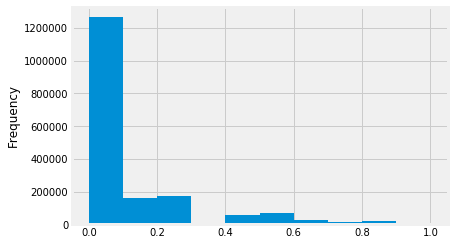

In [8]:
train_df.target.plot.hist()

Since for evaluation, the test set examples with target >= 0.5 will be considered to be in the positive class (toxic). The same notion will be applied here; The target from the train set will be transformed as bescribed above. 

0    1698436
1     106438
Name: target, dtype: int64


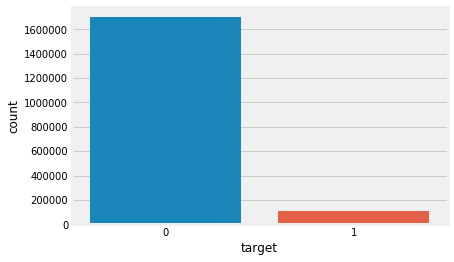

In [9]:
train_df.target = np.where(train_df.target> 0.5, 1, 0)
print(train_df.target.value_counts())
sns.countplot(train_df.target)

#### Rating Univariate analysis
Converting the character feature 'rating' which takes 2 values; approved and rejected into 1 and 0 respectively.

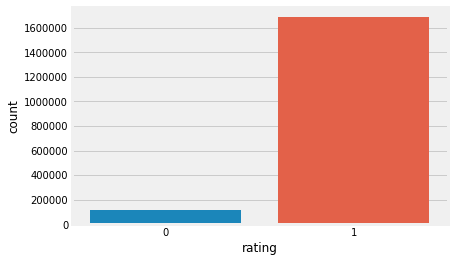

In [10]:
#train_df['rating'].value_counts()
train_df['rating'] = np.where(train_df['rating'] == "approved", 1, 0)
train_df['rating'].value_counts()
sns.countplot(train_df['rating'])

In [11]:
features = ['severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count']


toxicity_features = ["severe_toxicity", "obscene", "threat", "insult", "identity_attack", "sexual_explicit"]

identity_features = ["male", "female", "transgender", "other_gender", "heterosexual", "homosexual_gay_or_lesbian",
                     "bisexual", "other_sexual_orientation", "christian", "jewish", "muslim", "hindu", "buddhist",
                     "atheist", "other_religion", "black", "white", "asian", "latino", "other_race_or_ethnicity",
                     "physical_disability", "intellectual_or_learning_disability", "psychiatric_or_mental_illness", "other_disability"]

metadata_features = ["rating", "funny", "wow", "sad", "likes", "disagree", "toxicity_annotator_count", "identity_annotator_count"]

In [12]:
train_df[features].head()

,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0.0,0,4
59849,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0.0,0,4
59852,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0.0,0,4
59855,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0.0,0,4
59856,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0.0,4,47


Distributions columns


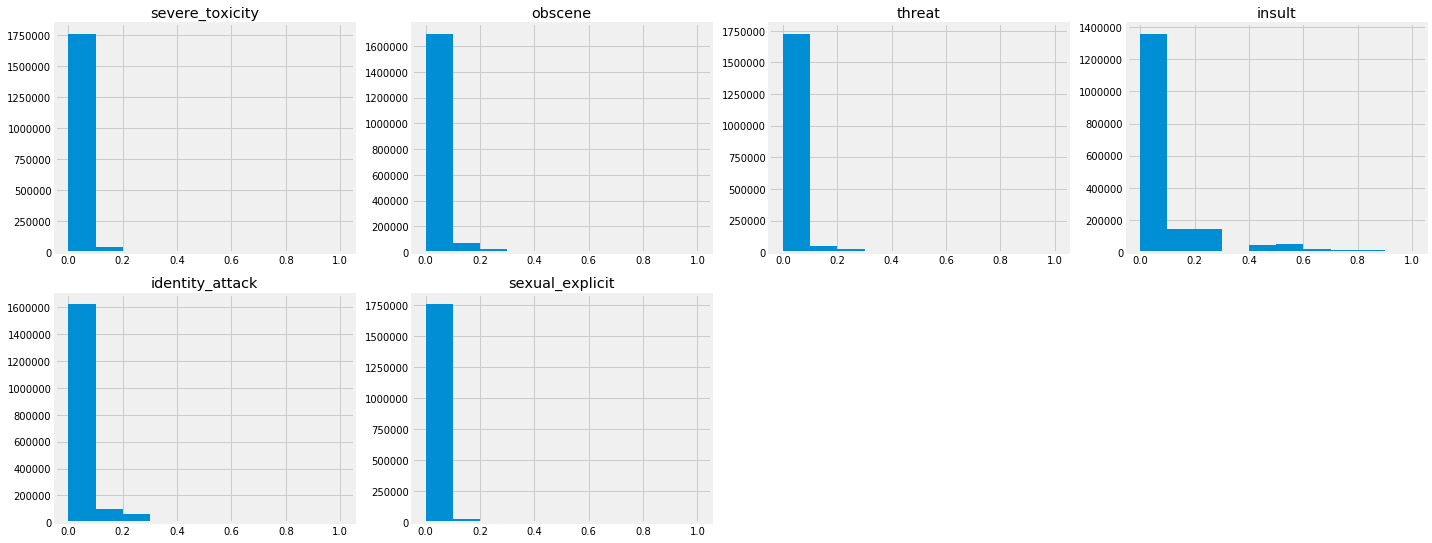

In [13]:
print('Distributions columns')
plt.figure(figsize=(20, 150))
for i, col in enumerate(toxicity_features):
    plt.subplot(40, 4, i + 1)
    plt.hist(train_df[col]) 
    plt.title(col)
plt.tight_layout()

Distributions columns


/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


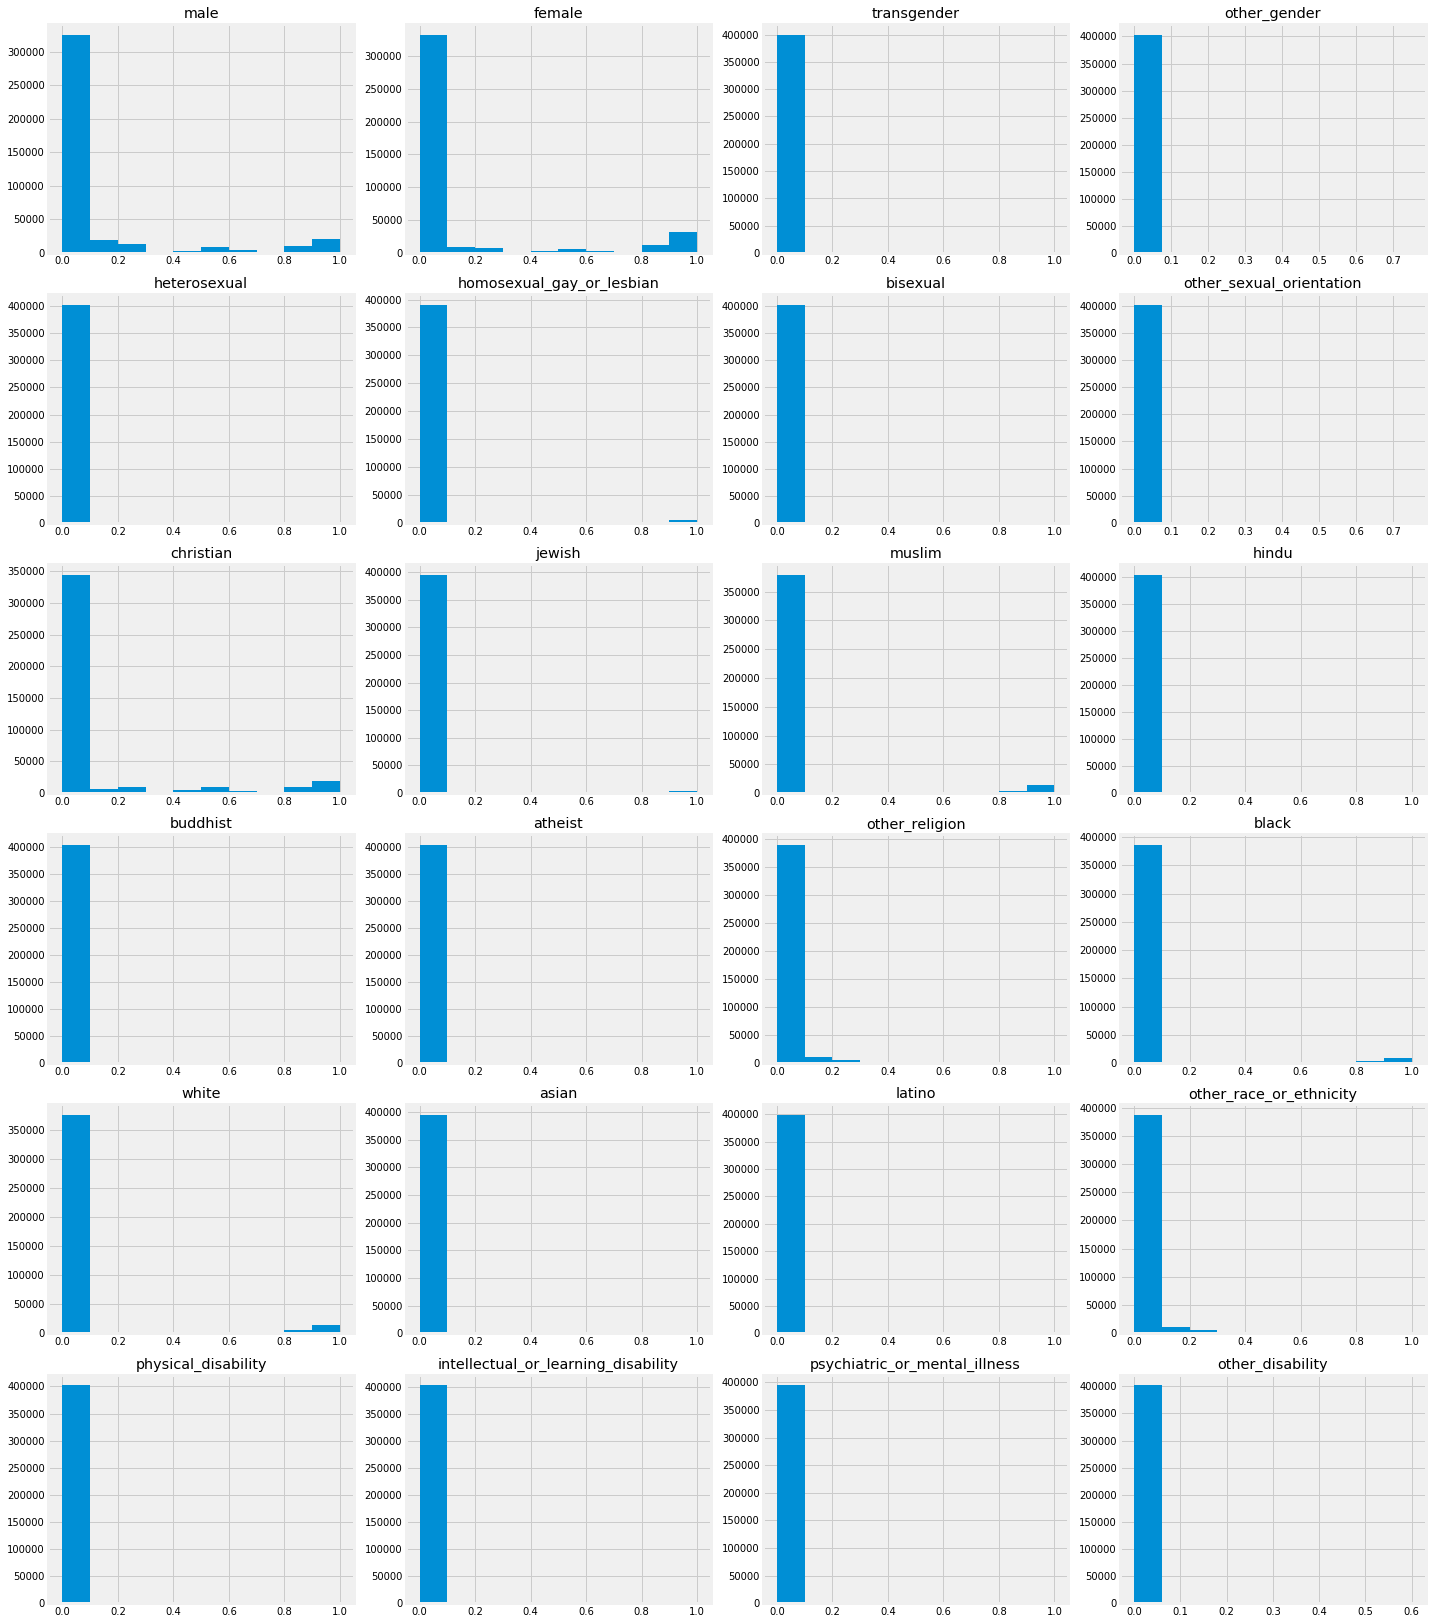

In [14]:
print('Distributions columns')
plt.figure(figsize=(20, 150))
for i, col in enumerate(identity_features):
    plt.subplot(40, 4, i + 1)
    plt.hist(train_df[col]) 
    plt.title(col)
plt.tight_layout()

Distributions columns


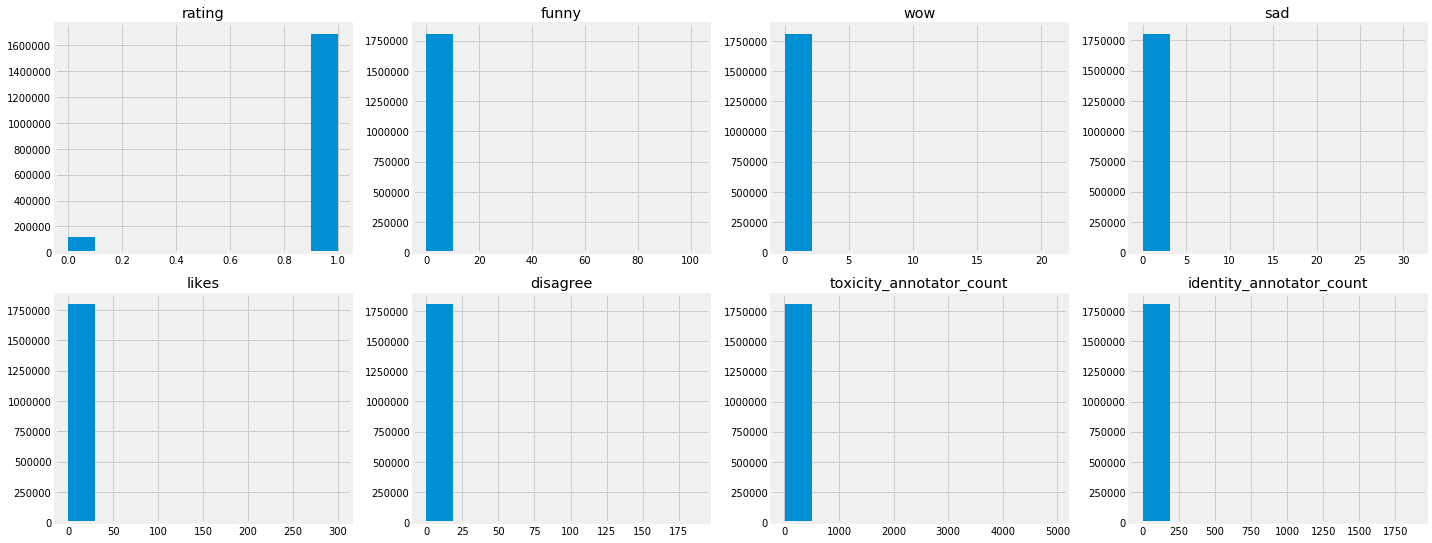

In [15]:
print('Distributions columns')
plt.figure(figsize=(20, 150))
for i, col in enumerate(metadata_features):
    plt.subplot(40, 4, i + 1)
    plt.hist(train_df[col]) 
    plt.title(col)
plt.tight_layout()

Distributions columns


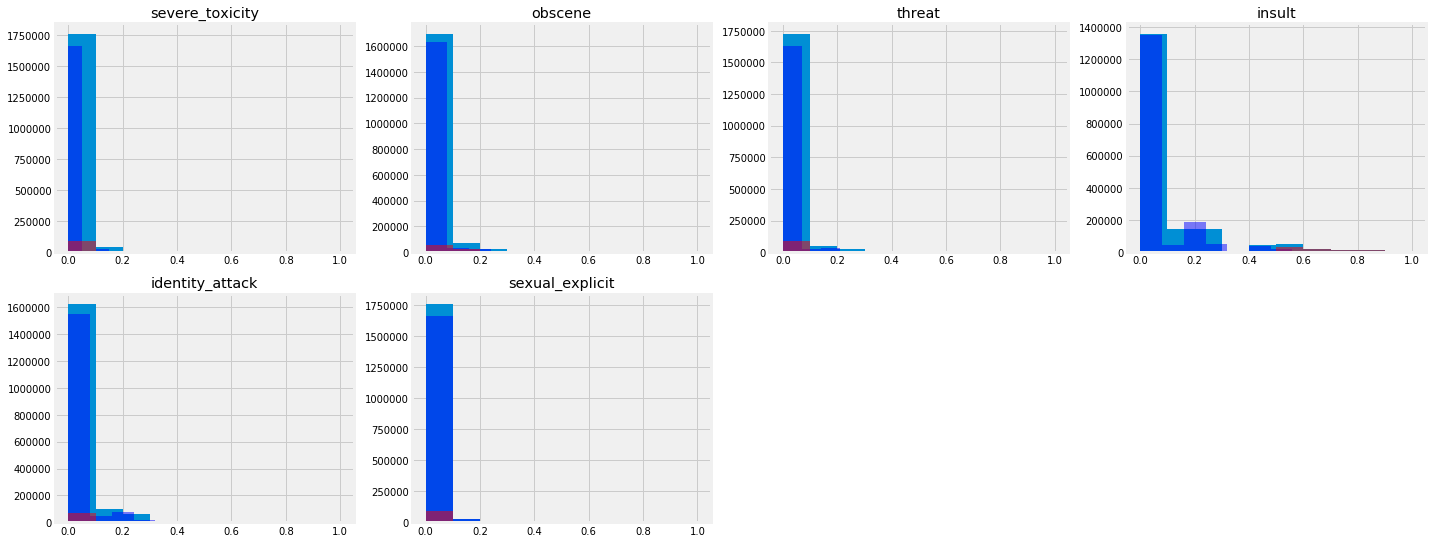

In [16]:
print('Distributions columns')
plt.figure(figsize=(20, 150))
for i, col in enumerate(toxicity_features):
    plt.subplot(40, 4, i + 1)
    plt.hist(train_df[col]) 
    plt.hist(train_df[train_df["target"] == 0][col], alpha=0.5, label='0', color='b')
    plt.hist(train_df[train_df["target"] == 1][col], alpha=0.5, label='1', color='r') 
    plt.title(col)
plt.tight_layout()

Distributions columns


/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


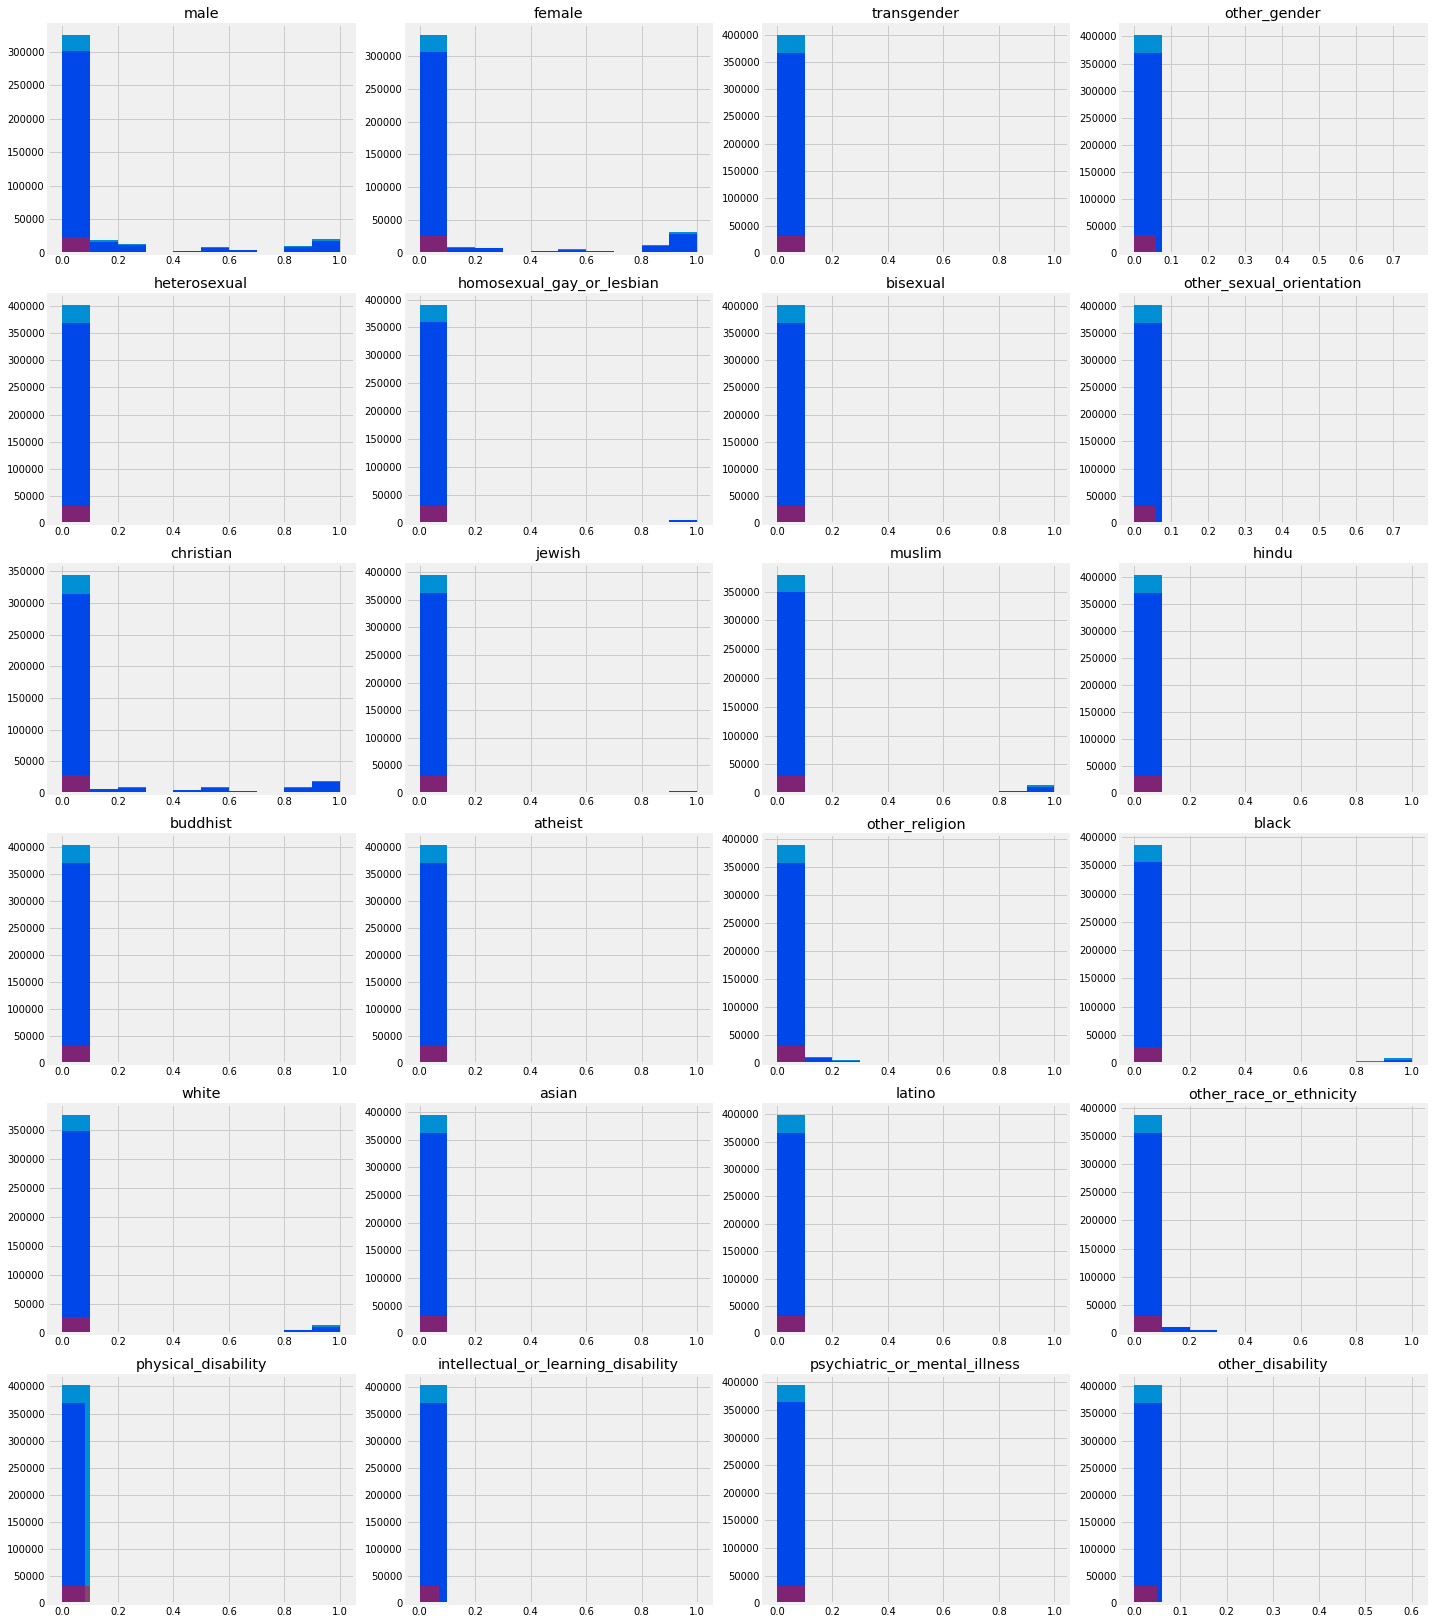

In [17]:
print('Distributions columns')
plt.figure(figsize=(20, 150))
for i, col in enumerate(identity_features):
    plt.subplot(40, 4, i + 1)
    plt.hist(train_df[col]) 
    plt.hist(train_df[train_df["target"] == 0][col], alpha=0.5, label='0', color='b')
    plt.hist(train_df[train_df["target"] == 1][col], alpha=0.5, label='1', color='r') 
    plt.title(col)
plt.tight_layout()

Distributions columns


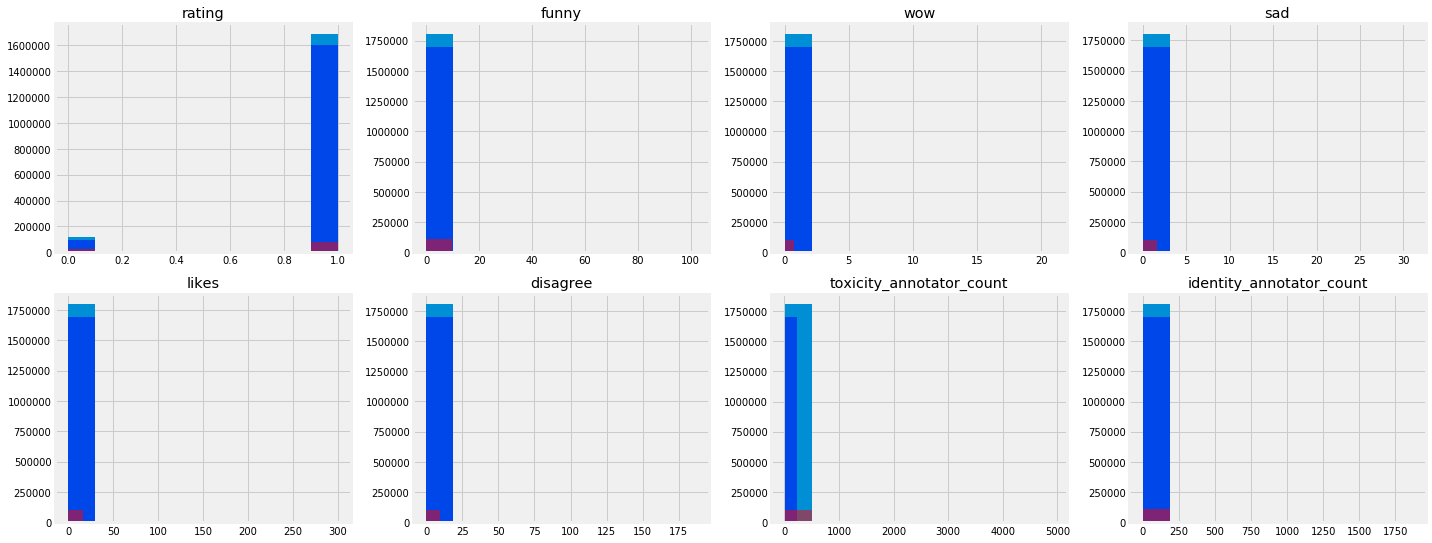

In [18]:
print('Distributions columns')
plt.figure(figsize=(20, 150))
for i, col in enumerate(metadata_features):
    plt.subplot(40, 4, i + 1)
    plt.hist(train_df[col]) 
    plt.hist(train_df[train_df["target"] == 0][col], alpha=0.5, label='0', color='b')
    plt.hist(train_df[train_df["target"] == 1][col], alpha=0.5, label='1', color='r') 
    plt.title(col)
plt.tight_layout()

In [19]:
plt.close();
gc.collect();

In [20]:
train_data = train_df["comment_text"]
label_data = train_df["target"]
test_data = test_df["comment_text"]
train_data.shape, label_data.shape, test_data.shape

((1804874,), (1804874,), (97320,))

In [21]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(train_data) + list(test_data))

In [22]:
train_data = tokenizer.texts_to_sequences(train_df['comment_text'])
test_data = tokenizer.texts_to_sequences(test_df['comment_text'])

In [23]:
MAX_LEN = 200
train_data = sequence.pad_sequences(train_data, maxlen=MAX_LEN)
test_data = sequence.pad_sequences(test_data, maxlen=MAX_LEN)

xtrain, xvalid, ytrain, yvalid = train_test_split(train_data, label_data, stratify=train_df.target, random_state=42, test_size=0.2, shuffle=True)

In [24]:
max_features = len(tokenizer.word_index) + 1
max_features

410047

In [25]:
embedding_path1 = "../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec"
#embedding_path2 = "../input/glove840b300dtxt/glove.840B.300d.txt"
embed_size = 300

def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

def build_matrix(embedding_path, tokenizer):
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))

    word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.zeros((nb_words + 1, embed_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = build_matrix(embedding_path1, tokenizer)

In [26]:
del train_data;
del train_df;
del test_df;
del tokenizer;
gc.collect();

In [27]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [37]:
NUM_HIDDEN = 256
EMB_SIZE = 300
LABEL_SIZE = 1
MAX_FEATURES = max_features
DROP_OUT_RATE = 0.2
DENSE_ACTIVATION = "sigmoid"
NUM_EPOCH = 5
conv_size = 128

BATCH_SIZE = 512
LOSS_FUNC = "binary_crossentropy"
OPTIMIZER_FUNC = "adam"
METRICS = ["accuracy"]

from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)


model=Sequential()
model.add(Embedding(max_features, EMB_SIZE, weights=[embedding_matrix], trainable=False))
#model.add(keras.layers.Embedding(max_features, EMB_SIZE))
model.add(SpatialDropout1D(DROP_OUT_RATE))
model.add(LSTM(NUM_HIDDEN, return_sequences=True))
#model.add(Dropout(rate=DROP_OUT_RATE))
model.add(Conv1D(conv_size, 2, activation='relu', padding='same'))
model.add(MaxPooling1D(5, padding='same'))
model.add(Conv1D(conv_size, 3, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
#model.add(Flatten())
model.add(Dense(LABEL_SIZE, activation=DENSE_ACTIVATION))

checkpointer = ModelCheckpoint(monitor='val_acc', mode='max', filepath='model.hdf5', verbose=2, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=0, mode='max')

model.compile(loss=LOSS_FUNC, optimizer=OPTIMIZER_FUNC, metrics=METRICS)

history_lstm = model.fit(
    xtrain, 
    ytrain, 
    batch_size = BATCH_SIZE, 
    epochs = NUM_EPOCH, callbacks=[checkpointer, earlyStopping],
validation_data=(xvalid, yvalid))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1443899 samples, validate on 360975 samples
Epoch 1/5
1443899/1443899 [==============================] - 820s 568us/step - loss: 0.1087 - acc: 0.9602 - val_loss: 0.0922 - val_acc: 0.9645

Epoch 00001: val_acc improved from -inf to 0.96450, saving model to model.hdf5
Epoch 2/5
1443899/1443899 [==============================] - 790s 547us/step - loss: 0.0928 - acc: 0.9643 - val_loss: 0.0884 - val_acc: 0.9660

Epoch 00002: val_acc improved from 0.96450 to 0.96598, saving model to model.hdf5
Epoch 3/5
1443899/1443899 [==============================] - 762s 528us/step - loss: 0.0879 - acc: 0.9662 - val_loss: 0.0898 - val_acc: 0.9654

Epoch 00003: val_acc did not improve from 0.96598
Epoch 4/5
1443899/1443899 [==============================] - 763s 529us/step - loss: 0.0862 - acc: 0.9668 - val_loss: 0.0873 - val_acc: 0.9658

Epoch 00004: val_acc did not impro

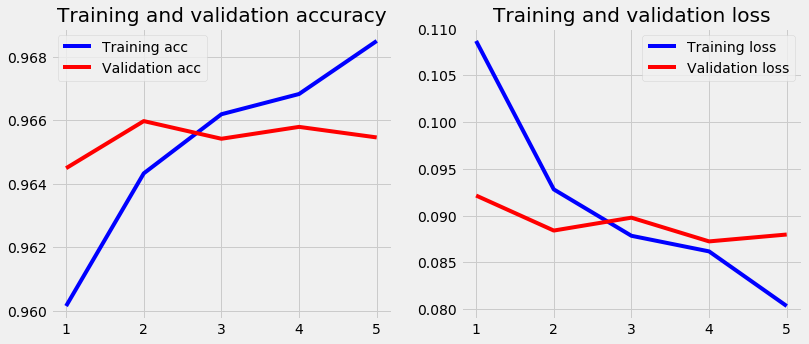

In [38]:
plot_history(history_lstm)

360975/360975 [==============================] - 44s 121us/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    339687
           1       0.73      0.65      0.69     21288

   micro avg       0.97      0.97      0.97    360975
   macro avg       0.86      0.82      0.84    360975
weighted avg       0.96      0.97      0.96    360975


accuracy_score 0.9654657524759332

Weighted Averaged validation metrics
precision_score 0.9639251046991881
recall_score 0.9654657524759332
f1_score 0.9645576189076042



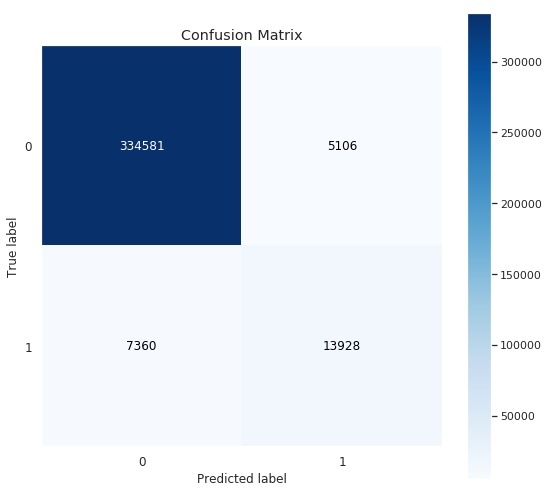

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

y_pred_lstm = model.predict_classes(xvalid, verbose=1, batch_size = BATCH_SIZE)
print(classification_report(yvalid, y_pred_lstm))

print()
print("accuracy_score", accuracy_score(yvalid, y_pred_lstm))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, y_pred_lstm, average='weighted'))
print("recall_score", recall_score(yvalid, y_pred_lstm, average='weighted'))
print("f1_score", f1_score(yvalid, y_pred_lstm, average='weighted'))

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, y_pred_lstm)

In [41]:
submission_in = '../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv'
submission_out = 'submission.csv'
result = model.predict(test_data, verbose=1, batch_size = BATCH_SIZE)

submission = pd.read_csv(submission_in, index_col='id')
submission['prediction'] = result
submission.reset_index(drop=False, inplace=True)
submission.to_csv('submission.csv',index=False)

97320/97320 [==============================] - 12s 125us/step
